In [1]:
# =====================================================
# 1. IMPORT LIBRARIES
# =====================================================

import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
# =====================================================
# 2. LOAD DATA
# =====================================================

# Pastikan path ini sesuai dengan lokasi file Anda di Google Drive/Lokal
historical = pd.read_csv("/content/drive/MyDrive/Skripsi/Dataset/Wind Power/wind farm historical data.csv")
nwp = pd.read_csv("/content/drive/MyDrive/Skripsi/Dataset/Wind Power/NWP.csv")

historical.columns = historical.columns.str.strip()
nwp.columns = nwp.columns.str.strip()

# Convert datetime
historical['Date'] = pd.to_datetime(historical['Date'], dayfirst=True)
nwp['time'] = pd.to_datetime(nwp['time'], format='mixed')

# Rename columns
historical = historical.rename(columns={
    'Date':'timestamp',
    'Speed':'wind_speed',
    'Direction':'wind_direction',
    'Energy':'power'
})

nwp = nwp.rename(columns={
    'time':'timestamp',
    'mod':'wind_speed_nwp',
    'dir':'wind_dir_nwp',
    'temp':'temperature_nwp',
    'rh':'humidity_nwp',
    'mslp':'pressure_nwp'
})

# Merge
data = pd.merge(historical, nwp, on='timestamp', how='inner')
data = data.sort_values('timestamp').reset_index(drop=True)
data = data.ffill().dropna()

print("Merged shape:", data.shape)

Merged shape: (8784, 9)


In [3]:
# =====================================================
# 3. FEATURE ENGINEERING (DENGAN NOVELTY FISIKA)
# =====================================================

data_fe = data.copy()

# Time features
data_fe['hour'] = data_fe['timestamp'].dt.hour
data_fe['month'] = data_fe['timestamp'].dt.month
data_fe['year'] = data_fe['timestamp'].dt.year

data_fe['hour_sin'] = np.sin(2*np.pi*data_fe['hour']/24)
data_fe['hour_cos'] = np.cos(2*np.pi*data_fe['hour']/24)
data_fe['month_sin'] = np.sin(2*np.pi*data_fe['month']/12)
data_fe['month_cos'] = np.cos(2*np.pi*data_fe['month']/12)

# Lag features
for lag in [1,2,3,6,12,24]:
    data_fe[f'power_lag_{lag}'] = data_fe['power'].shift(lag)

# Rolling features
data_fe['rolling_mean_6'] = data_fe['power'].rolling(6).mean()
data_fe['rolling_std_6'] = data_fe['power'].rolling(6).std()

In [4]:
# -------------------------------------------------------------------
# NOVELTY: PHYSICS-INFORMED FEATURES (DYNAMIC PRESSURE MODEL)
# Mengadaptasi pendekatan fisika dari jurnal Huang & Jiang (2022)
# -------------------------------------------------------------------

# 1. Konversi suhu dari Celcius ke Kelvin (T)
data_fe['temp_kelvin'] = data_fe['temperature_nwp'] + 273.15

# 2. Konversi tekanan (mslp) dari hPa/mbar ke Pascal (P)
data_fe['pressure_pascal'] = data_fe['pressure_nwp'] * 100

# 3. Menghitung Air Density / Densitas Udara (rho) menggunakan Hukum Gas Ideal
# Konstanta R spesifik untuk udara kering = 287.058 J/(kg·K)
R_specific = 287.058
data_fe['air_density'] = data_fe['pressure_pascal'] / (R_specific * data_fe['temp_kelvin'])

# 4. Potensi Daya Teoritis Fisika (P_W = 0.5 * rho * V^3)
# Menggunakan wind_speed_nwp karena ini adalah data ramalan cuaca yang menjadi input
data_fe['physics_theoretical_power'] = 0.5 * data_fe['air_density'] * (data_fe['wind_speed_nwp']**3)

# Fitur turunan non-linear tambahan
data_fe['wind_speed_cubed'] = data_fe['wind_speed']**3
data_fe['density_x_speed'] = data_fe['air_density'] * data_fe['wind_speed_nwp']

# -------------------------------------------------------------------

data_fe = data_fe.dropna().reset_index(drop=True)

print("After feature engineering:", data_fe.shape)

After feature engineering: (8760, 30)


In [5]:
# =====================================================
# 4. ROLLING WALK-FORWARD VALIDATION + HYPERPARAMETER TUNING
# =====================================================

test_months = [10, 11, 12]

results = []

features = data_fe.drop(
    ['timestamp','power','year','month'],
    axis=1
).columns

# Search space hyperparameter
param_dist = {
    'n_estimators': [400, 600, 800],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.5]
}

for month in test_months:

    train_data = data_fe[data_fe['month'] < month]
    test_data = data_fe[data_fe['month'] == month]

    if len(train_data) == 0 or len(test_data) == 0:
        continue

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_data[features])
    X_test = scaler.transform(test_data[features])

    y_train = train_data['power']
    y_test = test_data['power']

    # =====================================
    # HYPERPARAMETER TUNING
    # =====================================

    tscv = TimeSeriesSplit(n_splits=3)

    base_model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )

    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=20,  # jangan terlalu besar agar tidak lama
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    print(f"\nBest Params Month {month}:")
    print(random_search.best_params_)

    # =====================================
    # PREDICTION
    # =====================================

    preds = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mean_y_test = np.mean(y_test) if np.mean(y_test) != 0 else 1e-10
    nrmse = rmse / mean_y_test

    results.append({
        'Month': month,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'nRMSE': nrmse
    })

    print(f"===== Test Month {month} =====")
    print("RMSE:", round(rmse,2))
    print("MAE:", round(mae,2))
    print("R2:", round(r2,4))
    print("nRMSE:", round(nrmse,4))


Best Params Month 10:
{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.9}
===== Test Month 10 =====
RMSE: 94.24
MAE: 62.07
R2: 0.9304
nRMSE: 0.3377

Best Params Month 11:
{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}
===== Test Month 11 =====
RMSE: 146.45
MAE: 95.58
R2: 0.9439
nRMSE: 0.2773

Best Params Month 12:
{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.9}
===== Test Month 12 =====
RMSE: 136.45
MAE: 86.42
R2: 0.8863
nRMSE: 0.4103


In [6]:
# =====================================================
# 5. SUMMARY STATISTICS
# =====================================================

results_df = pd.DataFrame(results)

print("\n========== ROLLING VALIDATION SUMMARY ==========")
print(results_df)

print("\nAverage RMSE:", round(results_df['RMSE'].mean(),2))
print("Std RMSE:", round(results_df['RMSE'].std(),2))
print("Average R2:", round(results_df['R2'].mean(),4))
print("Average nRMSE:", round(results_df['nRMSE'].mean(),4))


========== ROLLING VALIDATION SUMMARY ==========
   Month        RMSE        MAE        R2     nRMSE
0     10   94.241149  62.074666  0.930386  0.337667
1     11  146.445964  95.581013  0.943878  0.277311
2     12  136.448676  86.421571  0.886260  0.410336

Average RMSE: 125.71
Std RMSE: 27.71
Average R2: 0.9202
Average nRMSE: 0.3418


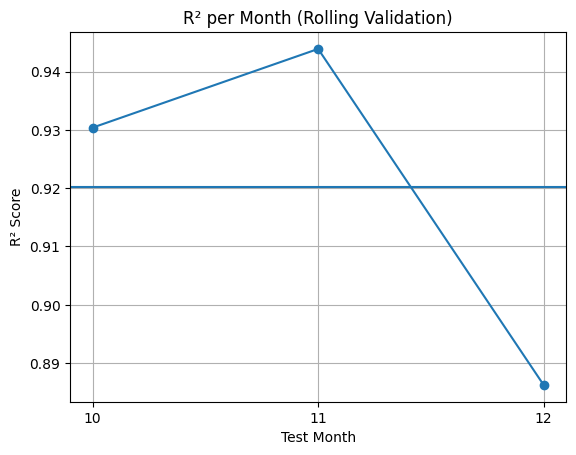

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata R2
avg_r2 = results_df['R2'].mean()

plt.figure()
plt.plot(results_df['Month'], results_df['R2'], marker='o')
plt.axhline(y=avg_r2)

plt.title('R² per Month (Rolling Validation)')
plt.xlabel('Test Month')
plt.ylabel('R² Score')

plt.xticks(results_df['Month'])
plt.grid(True)

plt.show()